# Good Film // Bad Film
## Film Plot Synopses and etc. as Predictors of Critical Reception

This notebook builds and evaluates a handful of regression models which predict critical reception scores for films. Independent variables include plot synopsis free text, social media metrics on the leading actors, and other categorical variables such as film genre.

In [3]:
import os
import time
import pickle
from unicodedata import normalize

import requests
from pycountry import languages

import pandas as pd
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt

from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Data Collection

## Kaggle Dataset

From https://www.kaggle.com/tmdb/tmdb-movie-metadata:

In [4]:
kaggle_data = pd.read_csv('../data/imdb_5000_movies.csv') # Just a big Kaggle dataset full of movies.

In [5]:
kaggle_data.shape

(5043, 28)

## Extra Metadata from TheMovieDB.org

One good thing about this dataset is that it provides the unique IMdB movie ID's, which we can pass to a third-party API in order to supplement our data with more features. Here we parse out those IMdB ID's:

In [6]:
kaggle_data.tail()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
5038,Color,Scott Smith,1.0,87.0,2.0,318.0,Daphne Zuniga,637.0,NaN,Comedy|Drama,...,6.0,English,Canada,NaN,NaN,2013.0,470.0,7.7,NaN,84
5039,Color,NaN,43.0,43.0,NaN,319.0,Valorie Curry,841.0,NaN,Crime|Drama|Mystery|Thriller,...,359.0,English,USA,TV-14,NaN,NaN,593.0,7.5,16.00,32000
5040,Color,Benjamin Roberds,13.0,76.0,0.0,0.0,Maxwell Moody,0.0,NaN,Drama|Horror|Thriller,...,3.0,English,USA,NaN,1400.0,2013.0,0.0,6.3,NaN,16
5041,Color,Daniel Hsia,14.0,100.0,0.0,489.0,Daniel Henney,946.0,10443.0,Comedy|Drama|Romance,...,9.0,English,USA,PG-13,NaN,2012.0,719.0,6.3,2.35,660
5042,Color,Jon Gunn,43.0,90.0,16.0,16.0,Brian Herzlinger,86.0,85222.0,Documentary,...,84.0,English,USA,PG,1100.0,2004.0,23.0,6.6,1.85,456


Grab IMdB ID numbers for each film and append to dataframe:

In [7]:
imdb_ids = kaggle_data['movie_imdb_link'].str[26:35]
# imdb_ids[3000:3005]

In [8]:
kaggle_data['imdb_ids'] = imdb_ids

Here we make the API calls, and persist our data to little .json files:

In [9]:
# You will need to enter your own API key in the API_KEY.py file (remove the .template suffix)
from API_KEY import API_KEY

try:
    os.mkdir('../data/movie_metadata')
except FileExistsError:
    pass

__This will make lots of API calls, be warned and use sparingly__, to avoid burning out your API key

In [10]:
# i=0; j=0; total=len(imdb_ids)

# for id in imdb_ids:
#     print(f"Downloading movie {i} of {total}...")
#     i+=1
#     query_string = f'https://api.themoviedb.org/3/movie/{id}?api_key={API_KEY}'
#     json = requests.get(query_string).text
#     if "could not be found" in json:
#         j+=1
#         print(f"{round(j/i, 2)}% of movies not found")
#         continue
#     f = open(f'../data/movie_metadata/movie_{id}.json', 'w+')
#     f.write(json)
#     f.close()

## Combine Kaggle Dataset and TheMovieDB API Responses

In [11]:
tmdb_movies = pd.DataFrame()

for filename in os.listdir(path='../data/movie_metadata/'):
    if "movie" in filename:
        this_movie = pd.read_json(f"../data/movie_metadata/{filename}", lines=True)
        tmdb_movies = pd.concat([this_movie,tmdb_movies], axis=0)

tmdb_movies = tmdb_movies.reset_index(drop=True)

In [12]:
df_merged = tmdb_movies.merge(kaggle_data, 
                              how='left',
                              left_on='imdb_id',
                              right_on='imdb_ids',
                              suffixes=("_kaggle","_api"))

In [13]:
df_merged.shape

(4925, 54)

# Data Cleaning and EDA

## Keep only interesting columns

In [14]:
df_merged.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget_kaggle',
       'genres_kaggle', 'homepage', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'poster_path',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'video', 'vote_average', 'vote_count', 'color', 'director_name',
       'num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'genres_api', 'actor_1_name', 'movie_title', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'content_rating', 'budget_api', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'imdb_ids'],
      dtyp

In [15]:
desired_cols = ("imdb_id duration adult budget_api budget_kaggle language original_language "
                "production_countries runtime spoken_languages color genres_api "
                "title movie_title original_title overview content_rating "
                "actor_1_facebook_likes actor_2_facebook_likes actor_3_facebook_likes "
                "director_facebook_likes cast_total_facebook_likes facenumber_in_poster "
                "aspect_ratio imdb_score revenue").split()

In [16]:
df_lesscols = df_merged[desired_cols]
df_lesscols.head()

,imdb_id,duration,adult,budget_api,budget_kaggle,language,original_language,production_countries,runtime,spoken_languages,...,content_rating,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,aspect_ratio,imdb_score,revenue
0,tt5215952,156.0,False,NaN,10951000,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",...,Not Rated,45.0,5.0,0.0,43.0,50,0.0,2.35,7.7,47098491
1,tt5078326,102.0,False,NaN,0,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",...,NaN,541.0,8.0,2.0,12.0,553,2.0,NaN,7.2,0
2,tt5001130,100.0,False,3500000.0,3500000,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,NaN,21.0,3.0,0.0,117.0,24,0.0,NaN,7.0,0
3,tt4939066,115.0,False,12620000.0,12700000,English,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",111.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",...,NaN,14000.0,81.0,29.0,32.0,14133,1.0,NaN,6.8,49196532
4,tt4871980,96.0,False,5000000.0,0,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",...,R,927.0,509.0,503.0,23.0,3552,6.0,NaN,4.5,0


## Drop Duplicate Rows

In [17]:
df_lesscols[
    df_lesscols.imdb_id.duplicated(keep=False)
].sort_values('imdb_id')[
    "imdb_id duration title language".split()
].head(51)

,imdb_id,duration,title,language
4865,tt0046672,127.0,"20,000 Leagues Under the Sea",English
4864,tt0046672,127.0,"20,000 Leagues Under the Sea",English
4837,tt0056193,152.0,Lolita,English
4838,tt0056193,152.0,Lolita,English
4792,tt0063350,96.0,Night of the Living Dead,English
4793,tt0063350,96.0,Night of the Living Dead,English
4758,tt0067116,104.0,The French Connection,English
4759,tt0067116,104.0,The French Connection,English
4728,tt0072271,88.0,The Texas Chain Saw Massacre,English
4727,tt0072271,88.0,The Texas Chain Saw Massacre,English


In [18]:
df_lesscols[
    df_lesscols.imdb_id.duplicated(keep=False)
].sort_values('imdb_id')[
    "imdb_id duration title language".split()
].tail(50)

,imdb_id,duration,title,language
962,tt1528100,150.0,Exodus: Gods and Kings,English
961,tt1528100,150.0,Exodus: Gods and Kings,English
853,tt1623205,130.0,Oz the Great and Powerful,English
852,tt1623205,130.0,Oz the Great and Powerful,English
805,tt1661199,105.0,Cinderella,English
804,tt1661199,105.0,Cinderella,English
795,tt1666335,108.0,The Calling,English
796,tt1666335,108.0,The Calling,English
787,tt1673434,115.0,The Twilight Saga: Breaking Dawn - Part 2,English
786,tt1673434,115.0,The Twilight Saga: Breaking Dawn - Part 2,English


In [19]:
df_lesscols = df_lesscols.drop_duplicates(subset='imdb_id').set_index("imdb_id")

In [21]:
df_lesscols.head(3)

,duration,adult,budget_api,budget_kaggle,language,original_language,production_countries,runtime,spoken_languages,color,...,content_rating,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,facenumber_in_poster,aspect_ratio,imdb_score,revenue
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,156.0,False,NaN,10951000,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,...,Not Rated,45.0,5.0,0.0,43.0,50,0.0,2.35,7.7,47098491
tt5078326,102.0,False,NaN,0,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,...,NaN,541.0,8.0,2.0,12.0,553,2.0,NaN,7.2,0
tt5001130,100.0,False,3500000.0,3500000,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,...,NaN,21.0,3.0,0.0,117.0,24,0.0,NaN,7.0,0


## Null Values Management

Here are all of the truly "null" values:

[]

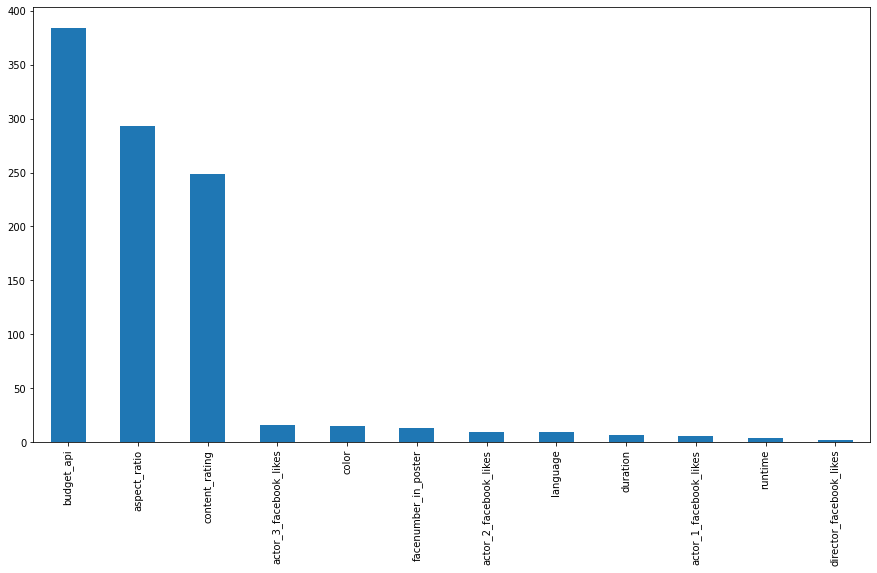

In [22]:
nulls = df_lesscols.isna().sum()[df_lesscols.isna().sum() > 0].sort_values(ascending=False)

nulls.plot(kind='bar', figsize=(15,8)).plot()

Gotta start somewhere.

### Budget

We have two disparate budget columns to draw from. We want whatever seems most plausible.

In [23]:
df_lesscols[["budget_api", "budget_kaggle"]].head(10)

,budget_api,budget_kaggle
imdb_id,,
tt5215952,NaN,10951000
tt5078326,NaN,0
tt5001130,3500000.0,3500000
tt4939066,12620000.0,12700000
tt4871980,5000000.0,0
tt4824308,5000000.0,5000000
tt4786282,4900000.0,4900000
tt4733536,990000.0,0
tt4707756,168000.0,0


Lots of nulls in budget_api, lots of zeroes in budget_kaggle. How best to handle this? And are there other columns where we just have a bunch of zero values instead of nulls (revenue??)

In [24]:
def best_guess_budget(row):
    # When budget_api is NaN and budget_kaggle is non-zero, take budget_kaggle.
    if row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return row['budget_kaggle']
    
    # When budget_api is not NaN but budget_kaggle is zero, take budget_api.
    elif not row.isna()["budget_api"] and row['budget_kaggle'] == 0:
        return row['budget_api']
    
    # When both values are not NaN / non-zero, take the mean?
    elif not row.isna()["budget_api"] and row['budget_kaggle'] != 0:
        return np.mean((row['budget_kaggle'], row['budget_api']))
        
    # When budget_api is NaN AND budget_kaggle is zero...that's tough. Maybe drop row. Consider imputing values?
    else:
        return None

In [25]:
df_lesscols.head(10).apply(best_guess_budget, axis=1)

imdb_id
tt5215952    10951000.0
tt5078326           NaN
tt5001130     3500000.0
tt4939066    12660000.0
tt4871980     5000000.0
tt4824308     5000000.0
tt4786282     4900000.0
tt4733536      990000.0
tt4707756      168000.0
tt4704314     2000000.0
dtype: float64

This is the desired behavior.

In [26]:
best_budget = df_lesscols.apply(best_guess_budget, axis=1)

In [27]:
df_best_guess_budget = df_lesscols.assign(best_budget=best_budget
                                         ).drop("budget_api budget_kaggle".split(), axis=1)

In [28]:
df_best_guess_budget.best_budget.isna().mean()

0.05579845929627316

5% of budget values are missing. I think I will in fact impute the median.

In [29]:
budget_med = df_best_guess_budget.best_budget.dropna().median()
budget_mean = df_best_guess_budget.best_budget.dropna().mean()
budget_med, budget_mean

(19000000.0, 36654712.14840132)

In [30]:
df_filled_budget = df_best_guess_budget.assign(
    filled_budget = df_best_guess_budget["best_budget"].fillna(budget_med)
).drop(["best_budget"],axis=1)

In [31]:
df_filled_budget.filled_budget.isna().mean()

0.0

In [32]:
df_filled_budget.filled_budget.median(), df_filled_budget.filled_budget.mean()

(19000000.0, 35669606.411201335)

This doesn't seem to have shifted the mean much, that's good.

### Aspect Ratio

In [33]:
df_filled_budget.aspect_ratio.isna().mean()

0.0610035394545076

6% of aspect ratios are null.

This is a categorical describing the dimensions of the projected image. Your TV set is 16x9 aka 1.77 aspect ratio, whereas lots of hollywood films are 1.85 ratio or 2.40, much "wider-screen". 2.40 might be "artsier".

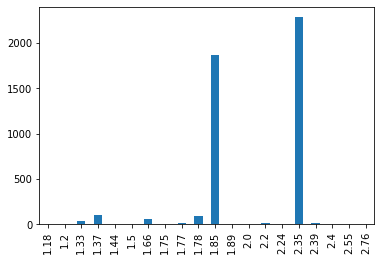

In [34]:
# Aspect ratio of 16 I take to mean 16x9 aka 1.77:
df_filled_budget.aspect_ratio = df_filled_budget.aspect_ratio.apply(lambda x: 1.77 if x==16 else x)
df_filled_budget.aspect_ratio.value_counts().sort_index().plot(kind="bar")

I think I will lump some of these together and impute 1.85 on null values. It's not *quite* the mode but it's a sort of middle-of-the road aspect ratio. The DCI standard lists 2.39 and 1.85 for theatrical projection. 16x9 or 1.77 is also common, and 4/3 or 1.33 is like an old-timey boxey aspect ratio.

In [35]:
aspect_bins = [0, np.mean((1.33, 1.77)), np.mean((1.77,1.85)), np.mean((1.85,2.39)), np.inf]
aspect_labels = "1.33 1.77 1.85 2.39".split()

In [36]:
pd.cut(df_filled_budget.aspect_ratio, 
       bins=aspect_bins, 
       labels=aspect_labels,
       include_lowest=True)

imdb_id
tt5215952    2.39
tt5078326     NaN
tt5001130     NaN
tt4939066     NaN
tt4871980     NaN
             ... 
tt0018737    1.33
tt0017136    1.33
tt0015624    1.33
tt0011549    1.33
tt0006864    1.33
Name: aspect_ratio, Length: 4803, dtype: category
Categories (4, object): [1.33 < 1.77 < 1.85 < 2.39]

Lump values and impute 1.85:

In [37]:
df_fixed_aspect = df_filled_budget.assign(fixed_aspect = pd.cut(df_filled_budget.aspect_ratio, 
                                                         bins=aspect_bins, 
                                                         labels=aspect_labels,
                                                         include_lowest=True
                                                               ).fillna("1.85")
                                         ).drop(["aspect_ratio"],axis=1)

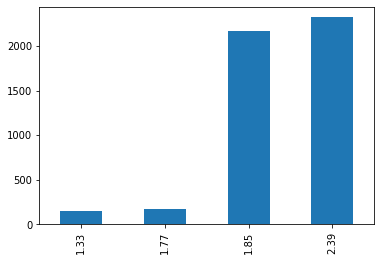

In [38]:
df_fixed_aspect.fixed_aspect.value_counts().sort_index().plot(kind="bar")

### Content Rating

In [39]:
df_fixed_aspect.content_rating.isna().mean()

0.051842598376014994

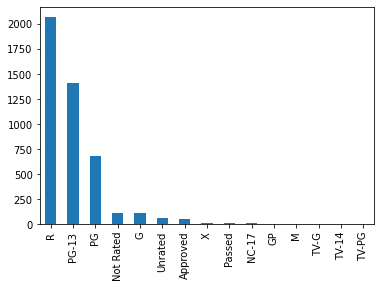

In [40]:
df_fixed_aspect.content_rating.value_counts().plot(kind="bar")

Just gonna fill nulls with PG-13 and condense redundant ones

In [41]:
df_content_rating_filled = df_fixed_aspect.assign(
                                content_rating=df_fixed_aspect.content_rating.fillna("PG-13")
                           )

In [42]:
def rating_mapper(rating):
    if rating == "Not Rated":
        return "Unrated"
    elif rating in "Approved Passed M TV-14".split():
        return "PG-13"
    elif rating in "TV-G GP G TV-PG".split():
        return "PG"
    elif rating in ["NC-17"]:
        return "X"
    else:
        return rating

In [43]:
df_content_rating_condensed = df_content_rating_filled.assign(
                                content_rating = df_content_rating_filled.content_rating.map(rating_mapper)
                              )

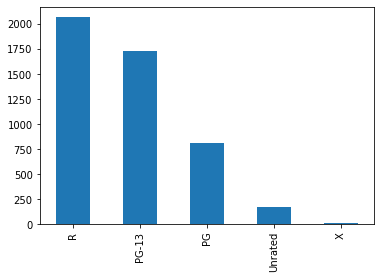

In [44]:
df_content_rating_condensed.content_rating.value_counts().plot(kind="bar")

In [45]:
df_content_rating_condensed.content_rating.isna().mean()

0.0

How are we doing on null values globally?

[]

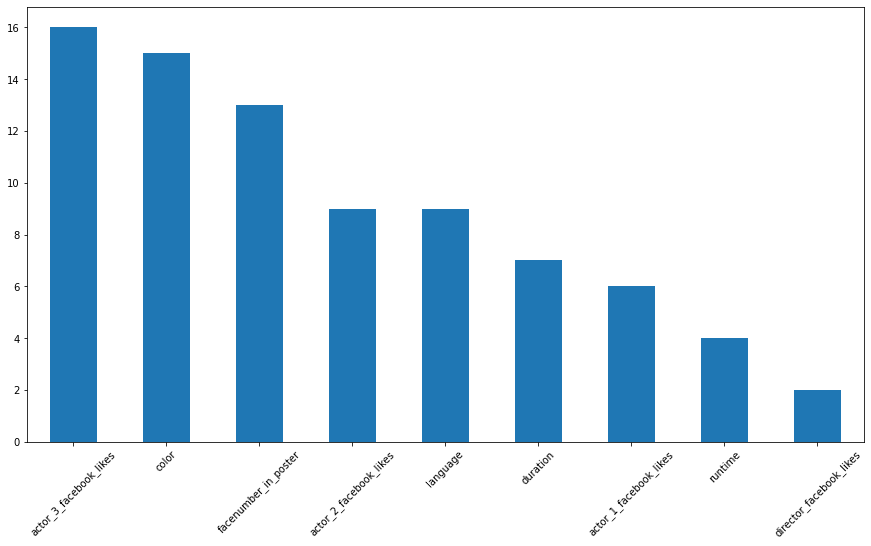

In [46]:
nulls_update = df_content_rating_condensed.isna().sum()[
    df_content_rating_condensed.isna().sum() > 0
].sort_values(ascending=False)

nulls_update.plot(kind='bar', figsize=(15,8), rot=45).plot()

Clearing some memory:

In [47]:
del nulls
del imdb_ids
del kaggle_data
del best_budget
del df_lesscols
del df_best_guess_budget
del df_filled_budget
del df_content_rating_filled
del df_fixed_aspect

### Facebook Like Counts

In [48]:
facebook_like_cols = [col for col in df_content_rating_condensed if "facebook" in col]
likes = df_content_rating_condensed[facebook_like_cols]

df_content_rating_condensed.drop(facebook_like_cols, axis=1, inplace=True)

likes.head()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,
tt5215952,45.0,5.0,0.0,43.0,50
tt5078326,541.0,8.0,2.0,12.0,553
tt5001130,21.0,3.0,0.0,117.0,24
tt4939066,14000.0,81.0,29.0,32.0,14133
tt4871980,927.0,509.0,503.0,23.0,3552


In [49]:
(round(likes.isna().mean()*100,2)).sort_values(ascending=False).astype('str')+"%"

actor_3_facebook_likes       0.33%
actor_2_facebook_likes       0.19%
actor_1_facebook_likes       0.12%
director_facebook_likes      0.04%
cast_total_facebook_likes     0.0%
dtype: object

Not that many values are missing. Will just use the medians.

In [50]:
likes.fillna({col:likes[col].median() for col in likes.columns}, inplace=True)

/Users/admin/.local/share/virtualenvs/Good-Film-Bad-Film-vaMlpeB4/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [51]:
df_likes_filled = pd.concat([df_content_rating_condensed,
                             likes], axis=1)

In [52]:
del df_content_rating_condensed
del likes

Time for another check-in:

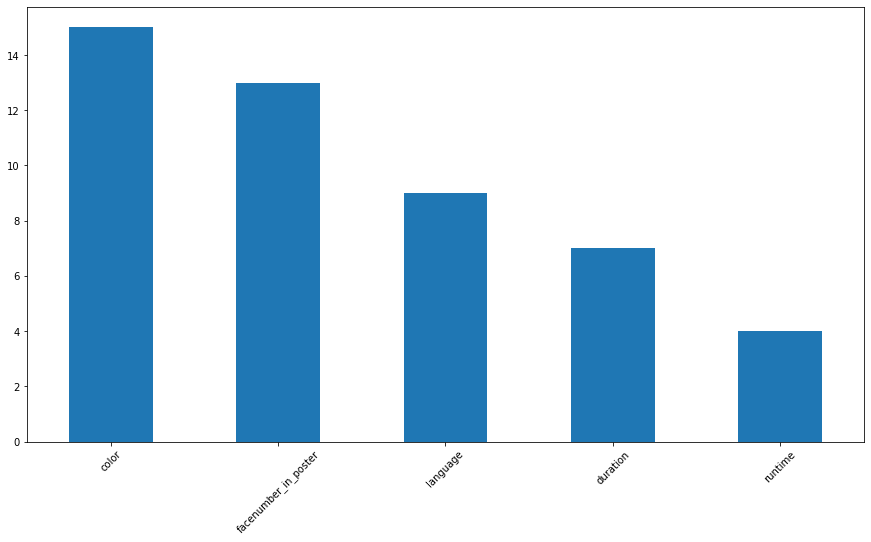

In [53]:
nulls_update = df_likes_filled.isna().sum()[
    df_likes_filled.isna().sum() > 0
].sort_values(ascending=False)

nulls_update.plot(kind='bar', figsize=(15,8), rot=45).plot()

del nulls_update

### Color

In [54]:
df_likes_filled.color = df_likes_filled.color.str.lstrip()
df_likes_filled.color.value_counts()

Color              4587
Black and White     201
Name: color, dtype: int64

Seems safe to assume that the last dozen films are in color...

In [55]:
df_likes_filled.color = df_likes_filled.color.fillna(df_likes_filled.color.mode()[0])
df_color_filled = df_likes_filled.copy()

In [56]:
del df_likes_filled

In [57]:
df_color_filled.head(3)

,duration,adult,language,original_language,production_countries,runtime,spoken_languages,color,genres_api,title,...,facenumber_in_poster,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,156.0,False,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,Fantasy|Horror|Mystery|Thriller,The Wailing,...,0.0,7.7,47098491,10951000.0,2.39,45.0,5.0,0.0,43.0,50
tt5078326,102.0,False,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,Comedy|Drama,The Country Doctor,...,2.0,7.2,0,19000000.0,1.85,541.0,8.0,2.0,12.0,553
tt5001130,100.0,False,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,Documentary,Time to Choose,...,0.0,7.0,0,3500000.0,1.85,21.0,3.0,0.0,117.0,24


In [58]:
df_color_filled.color.isna().mean()

0.0

### Face Number in Poster

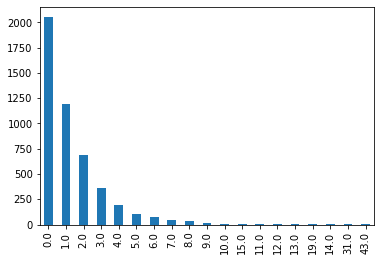

In [59]:
df_color_filled.facenumber_in_poster.value_counts().plot(kind='bar')

Zero seems to be a placeholder for "idk" in this dataset, I'll drop this column.

In [60]:
df_no_facenums = df_color_filled.drop(['facenumber_in_poster'],axis=1)
del df_color_filled
df_no_facenums.head()

,duration,adult,language,original_language,production_countries,runtime,spoken_languages,color,genres_api,title,...,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,156.0,False,Korean,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso...",Color,Fantasy|Horror|Mystery|Thriller,The Wailing,...,Unrated,7.7,47098491,10951000.0,2.39,45.0,5.0,0.0,43.0,50
tt5078326,102.0,False,French,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,"[{'iso_639_1': 'fr', 'name': 'Français'}]",Color,Comedy|Drama,The Country Doctor,...,PG-13,7.2,0,19000000.0,1.85,541.0,8.0,2.0,12.0,553
tt5001130,100.0,False,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,Documentary,Time to Choose,...,PG-13,7.0,0,3500000.0,1.85,21.0,3.0,0.0,117.0,24
tt4939066,115.0,False,English,ko,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",111.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Color,Action|Drama|History|War,Operation Chromite,...,PG-13,6.8,49196532,12660000.0,1.85,14000.0,81.0,29.0,32.0,14133
tt4871980,96.0,False,English,en,"[{'iso_3166_1': 'US', 'name': 'United States o...",96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Color,Comedy|Romance,The Perfect Match,...,R,4.5,0,5000000.0,1.85,927.0,509.0,503.0,23.0,3552


### Language ("original... spoken... language")

In [61]:
langs = df_no_facenums[[col for col in df_no_facenums.columns if "language" in col]]
langs.head(15)

,language,original_language,spoken_languages
imdb_id,,,
tt5215952,Korean,ko,"[{'iso_639_1': 'de', 'name': 'Deutsch'}, {'iso..."
tt5078326,French,fr,"[{'iso_639_1': 'fr', 'name': 'Français'}]"
tt5001130,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4939066,English,ko,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso..."
tt4871980,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4824308,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4786282,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4733536,English,en,"[{'iso_639_1': 'en', 'name': 'English'}]"
tt4707756,Romanian,ro,"[{'iso_639_1': 'ro', 'name': 'Română'}]"


In [62]:
langs.isna().mean()

language             0.001874
original_language    0.000000
spoken_languages     0.000000
dtype: float64

In [63]:
df_no_facenums.iloc[13,:]

duration                                                                   NaN
adult                                                                    False
language                                                                  Urdu
original_language                                                           ur
production_countries                [{'iso_3166_1': 'PK', 'name': 'Pakistan'}]
runtime                                                                    144
spoken_languages                         [{'iso_639_1': 'ur', 'name': 'اردو'}]
color                                                                    Color
genres_api                                                       Comedy|Family
title                                                        Karachi Se Lahore
movie_title                                                 Karachi se Lahore 
original_title                                                  کراچی سے لاہور
overview                     A road trip from Karach

The "language" column looks not great. "original language" is probably a better bet.

In [64]:
df_no_facenums.spoken_languages.tail()

imdb_id
tt0018737    [{'iso_639_1': 'xx', 'name': 'No Language'}]
tt0017136    [{'iso_639_1': 'xx', 'name': 'No Language'}]
tt0015624    [{'iso_639_1': 'xx', 'name': 'No Language'}]
tt0011549    [{'iso_639_1': 'xx', 'name': 'No Language'}]
tt0006864    [{'iso_639_1': 'xx', 'name': 'No Language'}]
Name: spoken_languages, dtype: object

In [65]:
df_no_facenums.original_language.tail()

imdb_id
tt0018737    de
tt0017136    de
tt0015624    en
tt0011549    en
tt0006864    en
Name: original_language, dtype: object

Yeah I think that's probably the best column.

In [66]:
df_no_facenums.original_language.value_counts().head(10)

en    4483
fr      74
es      34
hi      29
zh      27
de      27
ja      16
cn      14
ko      12
ru      11
Name: original_language, dtype: int64

Using a python package to make language codes human-readable:

In [67]:
lang_decoder = {lang.alpha_2: lang.name for lang in languages if hasattr(lang,'alpha_2')}
list(lang_decoder.items())[:5]

[('aa', 'Afar'),
 ('ab', 'Abkhazian'),
 ('af', 'Afrikaans'),
 ('ak', 'Akan'),
 ('am', 'Amharic')]

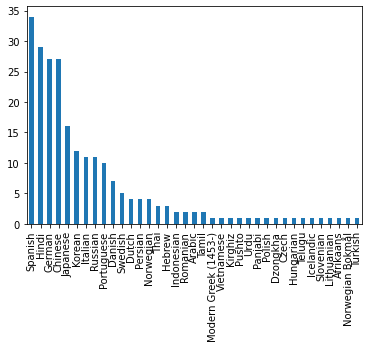

In [68]:
df_no_facenums.original_language = df_no_facenums.original_language.map(lang_decoder)
df_no_facenums.original_language.value_counts()[2:].plot(kind='bar')

Just eyeballing it...I think anything after German, in terms of frequency, is gonna have to go in "other"

Grabbing most popular languages:

In [69]:
top_langs = df_no_facenums.original_language.value_counts().index[:3].tolist()
top_langs

['English', 'French', 'Spanish']

In [70]:
def language_lumper(lang):
    if lang not in top_langs:
        return "Other"
    else:
        return lang

In [71]:
df_no_facenums.original_language = df_no_facenums.original_language.apply(language_lumper)

In [72]:
df_langs_lumped = df_no_facenums.drop("language spoken_languages".split(),axis=1)
del df_no_facenums
del langs

In [73]:
df_langs_lumped.head()

,duration,adult,original_language,production_countries,runtime,color,genres_api,title,movie_title,original_title,...,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,156.0,False,Other,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",156.0,Color,Fantasy|Horror|Mystery|Thriller,The Wailing,The Wailing,곡성,...,Unrated,7.7,47098491,10951000.0,2.39,45.0,5.0,0.0,43.0,50
tt5078326,102.0,False,French,"[{'iso_3166_1': 'FR', 'name': 'France'}]",102.0,Color,Comedy|Drama,The Country Doctor,Irreplaceable,Médecin de campagne,...,PG-13,7.2,0,19000000.0,1.85,541.0,8.0,2.0,12.0,553
tt5001130,100.0,False,English,"[{'iso_3166_1': 'US', 'name': 'United States o...",100.0,Color,Documentary,Time to Choose,Time to Choose,Time to Choose,...,PG-13,7.0,0,3500000.0,1.85,21.0,3.0,0.0,117.0,24
tt4939066,115.0,False,Other,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",111.0,Color,Action|Drama|History|War,Operation Chromite,Operation Chromite,인천상륙작전,...,PG-13,6.8,49196532,12660000.0,1.85,14000.0,81.0,29.0,32.0,14133
tt4871980,96.0,False,English,"[{'iso_3166_1': 'US', 'name': 'United States o...",96.0,Color,Comedy|Romance,The Perfect Match,The Perfect Match,The Perfect Match,...,R,4.5,0,5000000.0,1.85,927.0,509.0,503.0,23.0,3552


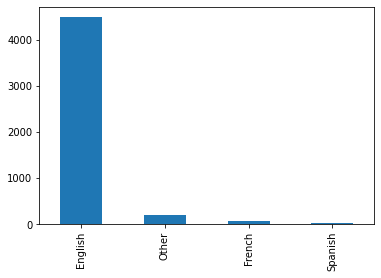

In [74]:
df_langs_lumped.original_language.value_counts().plot(kind='bar')

***

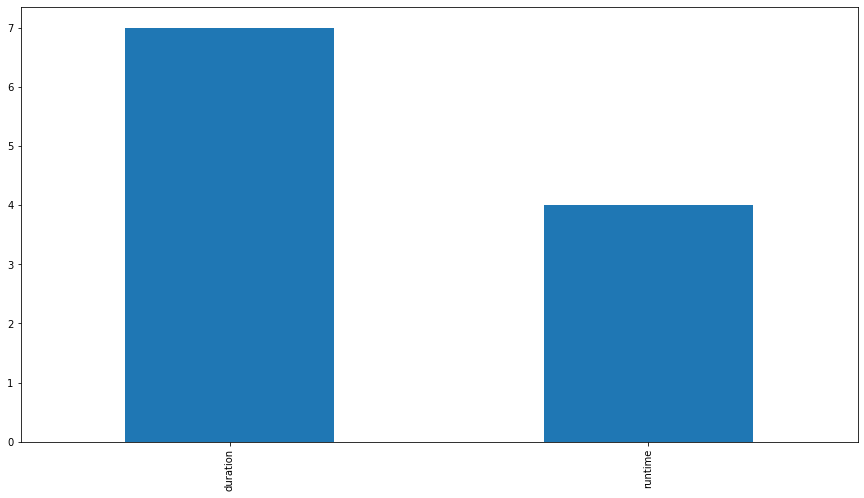

In [75]:
nulls = df_langs_lumped.isna().sum()[df_langs_lumped.isna().sum() > 0].sort_values(ascending=False)

nulls.plot(kind='bar', figsize=(15,8)).plot()

del nulls

### Duration / Runtime

In [76]:
durs = df_langs_lumped["duration runtime".split()]
durs.head()

,duration,runtime
imdb_id,,
tt5215952,156.0,156.0
tt5078326,102.0,102.0
tt5001130,100.0,100.0
tt4939066,115.0,111.0
tt4871980,96.0,96.0


How different are these columns?

0.9607679465776294

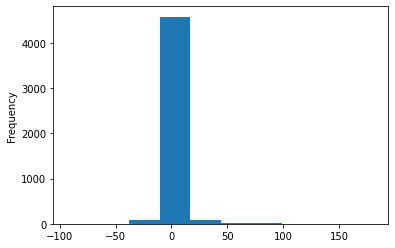

In [77]:
(durs.duration - durs.runtime).plot(kind='hist')
(durs.duration - durs.runtime).mean()

Not very.

In [78]:
df_langs_lumped.drop(["duration"],axis=1,inplace=True)

In [79]:
df_runtimes_filled = df_langs_lumped.assign(
    durations=df_langs_lumped.runtime.fillna(
        df_langs_lumped.runtime.median()
    )
).drop(["runtime"],axis=1)

del df_langs_lumped
del durs

In [80]:
df_runtimes_filled.isna().mean()

adult                        0.0
original_language            0.0
production_countries         0.0
color                        0.0
genres_api                   0.0
title                        0.0
movie_title                  0.0
original_title               0.0
overview                     0.0
content_rating               0.0
imdb_score                   0.0
revenue                      0.0
filled_budget                0.0
fixed_aspect                 0.0
actor_1_facebook_likes       0.0
actor_2_facebook_likes       0.0
actor_3_facebook_likes       0.0
director_facebook_likes      0.0
cast_total_facebook_likes    0.0
durations                    0.0
dtype: float64

**No more obvious nulls!**

In [81]:
df_runtimes_filled.to_pickle("../data/pickles/df_no_nulls.pkl")

## Categorical Columns

In [100]:
df_no_nulls = pd.read_pickle("../data/pickles/df_no_nulls.pkl")
df_no_nulls.columns.tolist()

['adult',
 'original_language',
 'production_countries',
 'color',
 'genres_api',
 'title',
 'movie_title',
 'original_title',
 'overview',
 'content_rating',
 'imdb_score',
 'revenue',
 'filled_budget',
 'fixed_aspect',
 'actor_1_facebook_likes',
 'actor_2_facebook_likes',
 'actor_3_facebook_likes',
 'director_facebook_likes',
 'cast_total_facebook_likes',
 'durations']

### "Adult"

In [101]:
df_no_nulls.adult.value_counts()

False    4803
Name: adult, dtype: int64

Single-value column. Drop it

In [102]:
df_no_adult = df_no_nulls.drop(["adult"],axis=1)
del df_no_nulls

In [103]:
df_no_adult.columns

Index(['original_language', 'production_countries', 'color', 'genres_api',
       'title', 'movie_title', 'original_title', 'overview', 'content_rating',
       'imdb_score', 'revenue', 'filled_budget', 'fixed_aspect',
       'actor_1_facebook_likes', 'actor_2_facebook_likes',
       'actor_3_facebook_likes', 'director_facebook_likes',
       'cast_total_facebook_likes', 'durations'],
      dtype='object')

### Production Countries

In [104]:
df_no_adult['production_countries'].head()

imdb_id
tt5215952        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
tt5078326             [{'iso_3166_1': 'FR', 'name': 'France'}]
tt5001130    [{'iso_3166_1': 'US', 'name': 'United States o...
tt4939066        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
tt4871980    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

Hmm list of dict. Let's just grab the human-readable names:

In [105]:
def prod_countries_extractor(countries):
    if len(countries)!=0:
        return {country['name'] for country in countries}
    else:
        return {}

In [106]:
df_no_adult.production_countries = df_no_adult.production_countries.apply(prod_countries_extractor)

In [107]:
df_no_adult.production_countries.iloc[29:34]

imdb_id
tt4280822                    {United States of America}
tt4273494                                            {}
tt4263482    {United States of America, United Kingdom}
tt4262980                                       {Japan}
tt4257926                    {United States of America}
Name: production_countries, dtype: object

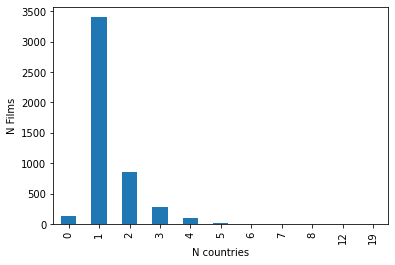

In [108]:
# Turns out pandas vectorized string operations work on lists too
ax = df_no_adult.production_countries.str.len().value_counts().sort_index().plot(kind='bar')
ax.set_xlabel("N countries")
ax.set_ylabel("N Films")
ax.plot()
del ax

I feel like that ^ can become an int column, after the zeroes are fixed

In [109]:
# If it's not in English, can we guess where it was filmed?
df_no_adult[(
                df_no_adult.production_countries.str.len()==0
            )&(
                df_no_adult.original_language!="English"
            )]

,original_language,production_countries,color,genres_api,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,durations
imdb_id,,,,,,,,,,,,,,,,,,,
tt2141739,Other,{},Color,Documentary|News,Food Chains,Food Chains,Food Chains,,PG-13,7.1,0,913000.0,1.85,56.0,28.0,17.0,0.0,104,83.0
tt0473553,Other,{},Color,Horror|Thriller,The Tooth Fairy,The Tooth Fairy,The Tooth Fairy,A woman and her daughter (Nicole Muñoz) encoun...,PG-13,4.6,0,1500000.0,1.77,598.0,555.0,235.0,42.0,2353,89.0
tt0432637,Other,{},Color,Action|Adventure|Romance|Sci-Fi,Krrish,Krrish,कृष,"In Singapore, Krishna is forced by circumstanc...",Unrated,6.3,0,10000000.0,2.39,307.0,200.0,45.0,53.0,616,174.0
tt0249588,Other,{},Color,Action|Comedy|Romance|Thriller,Hum To Mohabbat Karega,Hum To Mohabbat Karega,Hum To Mohabbat Karega,A man lies about being an eyewitness to a murd...,PG-13,2.8,0,19000000.0,1.85,353.0,89.0,72.0,4.0,613,148.0


In [110]:
guesses = {480:"Germany", 
           2051:"Germany",
           2260:"India",
           3242:"India"}

for index, country in guesses.items():
    df_no_adult['production_countries'].iloc[index] = country
    
del index
del country

/Users/admin/.local/share/virtualenvs/Good-Film-Bad-Film-vaMlpeB4/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [111]:
pd.DataFrame([df_no_adult.iloc[i,:] for i in guesses.keys()])

,original_language,production_countries,color,genres_api,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,fixed_aspect,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes,durations
tt2111292,English,Germany,Color,Action,Diamond Ruff,Diamond Ruff,Diamond Ruff,"Action - Orphan, con artist, crime boss and mi...",R,4.3,0,500000.0,1.85,472.0,251.0,237.0,5.0,1752,0.0
tt0462395,English,Germany,Color,Comedy|Romance,Larry the Cable Guy: Health Inspector,Larry the Cable Guy: Health Inspector,Larry the Cable Guy: Health Inspector,A slovenly cable repairman becomes a big-city ...,PG-13,3.1,0,4000000.0,1.33,690.0,400.0,323.0,0.0,2135,89.0
tt0421237,English,India,Color,Action|Thriller,Royal Kill,Royal Kill,Royal Kill,A fearsome warrior from the Kingdom of Samarza...,PG-13,3.2,0,350000.0,1.85,502.0,119.0,32.0,0.0,689,90.0
tt0229260,English,India,Color,Adventure|Fantasy|Horror|Mystery|Thriller,Book of Shadows: Blair Witch 2,Book of Shadows: Blair Witch 2,Book of Shadows: Blair Witch 2,Young adults become fascinated by the events o...,R,4.0,0,15000000.0,1.85,193.0,184.0,162.0,31.0,608,90.0


In [112]:
del guesses

In [113]:
df_no_adult.production_countries.value_counts().head(10)

TypeError: unhashable type: 'set'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'set'


{United States of America}                    2990
{United States of America, United Kingdom}     210
{}                                             136
{United States of America, Germany}            134
{United Kingdom}                               127
{Canada, United States of America}             103
{United States of America, Australia}           55
{France}                                        49
{Canada}                                        45
{United States of America, France}              43
Name: production_countries, dtype: int64

In [114]:
def fill_with_USA(country_set):
    return {"United States of America"} if country_set == {} else country_set

In [115]:
df_no_adult["production_countries"] = df_no_adult.production_countries.apply(fill_with_USA)

In [116]:
df_filled_USA = df_no_adult.copy()
del df_no_adult

Might need to split into USA and not-USA to deal with class imbalance

In [117]:
def usa_or_not(country_set):
    return 0 if country_set=={"United States of America"} else 1

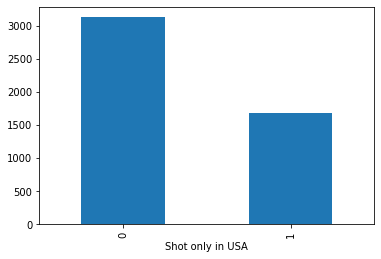

In [118]:
ax = df_filled_USA.production_countries.apply(usa_or_not).value_counts().plot(kind='bar')
ax.set_xlabel("Shot only in USA")
del ax

In [119]:
df_filled_USA['shot_only_in_USA'] = df_filled_USA.production_countries.apply(usa_or_not)

In [120]:
def shot_in_usa_and_abroad(country_set):
    if len(country_set)>1 and "United States of America" in country_set:
        return 1
    else:
        return 0

In [121]:
df_filled_USA['shot_in_USA_and_abroad'] = df_filled_USA.production_countries.apply(shot_in_usa_and_abroad)

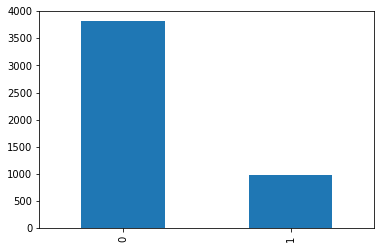

In [122]:
df_filled_USA['shot_in_USA_and_abroad'].value_counts().plot(kind='bar')

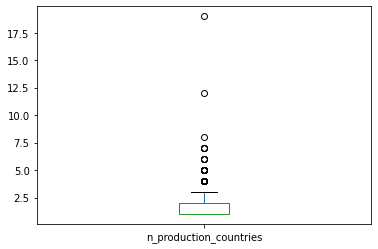

In [123]:
df_filled_USA['n_production_countries'] = df_filled_USA.production_countries.str.len()
df_filled_USA['n_production_countries'].plot(kind='box')

In [124]:
df_n_countries = df_filled_USA.drop(["production_countries"],axis=1)

In [125]:
del df_filled_USA

In [126]:
df_n_countries.columns.tolist()

['original_language',
 'color',
 'genres_api',
 'title',
 'movie_title',
 'original_title',
 'overview',
 'content_rating',
 'imdb_score',
 'revenue',
 'filled_budget',
 'fixed_aspect',
 'actor_1_facebook_likes',
 'actor_2_facebook_likes',
 'actor_3_facebook_likes',
 'director_facebook_likes',
 'cast_total_facebook_likes',
 'durations',
 'shot_only_in_USA',
 'shot_in_USA_and_abroad',
 'n_production_countries']

### Genre

In [127]:
df_n_countries['genre'] = df_n_countries['genres_api'].str.split("|")
df_n_countries['genre'] = df_n_countries['genre'].apply(lambda x: set(x))
del df_n_countries["genres_api"]

In [128]:
df_n_countries['genre'].apply(lambda x: set(x)).value_counts().head(20)

TypeError: unhashable type: 'set'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1653, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'set'


{Drama}                              230
{Comedy}                             196
{Drama, Comedy}                      187
{Drama, Romance, Comedy}             182
{Romance, Comedy}                    152
{Drama, Romance}                     147
{Crime, Thriller, Drama}              95
{Horror}                              67
{Crime, Action, Thriller}             62
{Drama, Thriller}                     61
{Crime, Thriller, Action, Drama}      61
{Crime, Drama}                        58
{Thriller, Horror}                    52
{Crime, Thriller, Drama, Mystery}     50
{Crime, Comedy}                       49
{Documentary}                         48
{Adventure, Action, Sci-Fi}           48
{Adventure, Action, Thriller}         44
{Biography, Drama}                    35
{Drama, Thriller, Mystery}            35
Name: genre, dtype: int64

In [129]:
genre_cats = "Drama Comedy Romance Crime Thriller Horror Action Mystery Sci-Fi Adventure Documentary".split()

In [130]:
def genre_encoder(genre_set):
    new = pd.Series(0, index=genre_cats)
    for genre in genre_set:
        if genre in genre_cats:
            new[genre] = 1
    return new

In [131]:
df_n_countries.genre.head()

imdb_id
tt5215952    {Fantasy, Thriller, Horror, Mystery}
tt5078326                         {Drama, Comedy}
tt5001130                           {Documentary}
tt4939066           {War, Drama, Action, History}
tt4871980                       {Romance, Comedy}
Name: genre, dtype: object

In [132]:
df_n_countries.genre.head().apply(genre_encoder)

,Drama,Comedy,Romance,Crime,Thriller,Horror,Action,Mystery,Sci-Fi,Adventure,Documentary
imdb_id,,,,,,,,,,,
tt5215952,0,0,0,0,1,1,0,1,0,0,0
tt5078326,1,1,0,0,0,0,0,0,0,0,0
tt5001130,0,0,0,0,0,0,0,0,0,0,1
tt4939066,1,0,0,0,0,0,1,0,0,0,0
tt4871980,0,1,1,0,0,0,0,0,0,0,0


In [133]:
genre_matrix = df_n_countries.genre.apply(genre_encoder)

In [134]:
del df_n_countries['genre']

In [135]:
genre_matrix.columns = ["".join(["genre_", col]) for col in genre_matrix.columns.tolist()]

In [136]:
df_encoded_genres = pd.concat([df_n_countries,genre_matrix],axis=1)

In [137]:
del df_n_countries
del genre_matrix
del genre_cats

In [138]:
df_encoded_genres.to_pickle("../data/pickles/df_encoded_genres.pkl")

## Numerical Columns

In [139]:
df_encoded_genres = pd.read_pickle("../data/pickles/df_encoded_genres.pkl")

In [140]:
df_encoded_genres.columns

Index(['original_language', 'color', 'title', 'movie_title', 'original_title',
       'overview', 'content_rating', 'imdb_score', 'revenue', 'filled_budget',
       'fixed_aspect', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
       'actor_3_facebook_likes', 'director_facebook_likes',
       'cast_total_facebook_likes', 'durations', 'shot_only_in_USA',
       'shot_in_USA_and_abroad', 'n_production_countries', 'genre_Drama',
       'genre_Comedy', 'genre_Romance', 'genre_Crime', 'genre_Thriller',
       'genre_Horror', 'genre_Action', 'genre_Mystery', 'genre_Sci-Fi',
       'genre_Adventure', 'genre_Documentary'],
      dtype='object')

### Facebook Likes

In [141]:
likes = df_encoded_genres[[col for col in df_encoded_genres.columns if "likes" in col]]
likes.head()

,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,director_facebook_likes,cast_total_facebook_likes
imdb_id,,,,,
tt5215952,45.0,5.0,0.0,43.0,50
tt5078326,541.0,8.0,2.0,12.0,553
tt5001130,21.0,3.0,0.0,117.0,24
tt4939066,14000.0,81.0,29.0,32.0,14133
tt4871980,927.0,509.0,503.0,23.0,3552


In [142]:
likes.actor_1_facebook_likes.describe()

count      4803.000000
mean       6599.710181
std       15242.735653
min           0.000000
25%         614.500000
50%         989.000000
75%       11000.000000
max      640000.000000
Name: actor_1_facebook_likes, dtype: float64

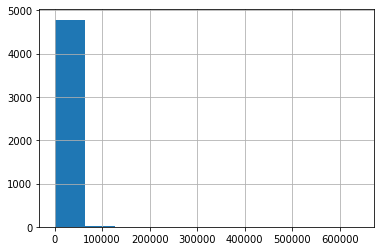

In [143]:
likes.actor_1_facebook_likes.hist()

Could probably use a log transform or something. Or is it just full of zeroes?

In [144]:
likes.actor_1_facebook_likes[likes.actor_1_facebook_likes < 5].shape

(36,)

In [145]:
likes.director_facebook_likes[likes.director_facebook_likes == 0].shape

(872,)

In [146]:
likes.director_facebook_likes.describe()

count     4803.000000
mean       692.601915
std       2836.009407
min          0.000000
25%          7.000000
50%         48.000000
75%        190.500000
max      23000.000000
Name: director_facebook_likes, dtype: float64

I'm willing to believe that directors are just generally not as popular as their actors

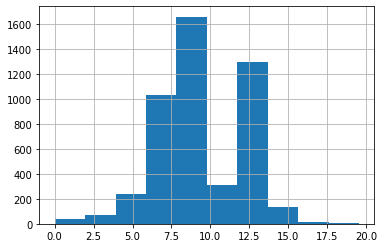

In [147]:
# +1 like for boxcox, does not like zeroes
pd.Series(boxcox(likes.actor_1_facebook_likes+1)[0]).hist()

Seems good

In [148]:
all_boxcoxed = [pd.Series(boxcox(likes[col]+1)[0], name=f"{col}_box") for col in likes.columns]

In [149]:
boxed_df = pd.concat(all_boxcoxed,axis=1)
boxed_df.index = df_encoded_genres.index
boxed_df.head()

,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box
imdb_id,,,,,
tt5215952,4.250035,1.917963,0.000000,3.648834,5.229121
tt5078326,7.488314,2.388995,1.198774,2.502277,10.108035
tt5001130,3.362001,1.461064,0.000000,4.556906,4.057789
tt4939066,12.467224,5.223879,4.491669,3.380737,19.933142
tt4871980,8.253012,7.951943,10.534436,3.082217,15.201223


actor_1_facebook_likes_box


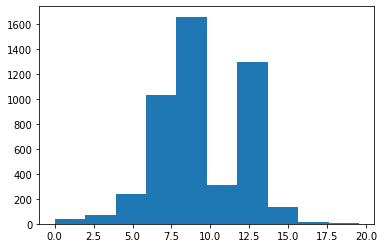

actor_2_facebook_likes_box


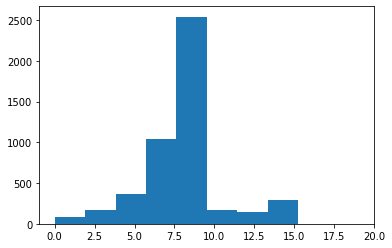

actor_3_facebook_likes_box


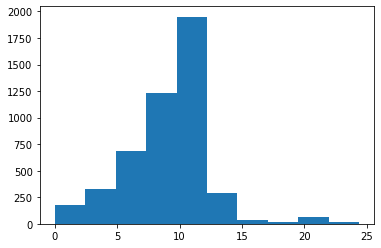

director_facebook_likes_box


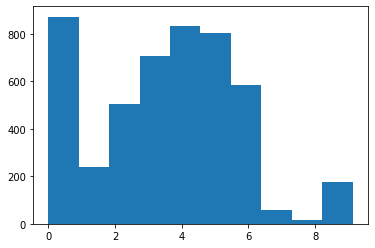

cast_total_facebook_likes_box


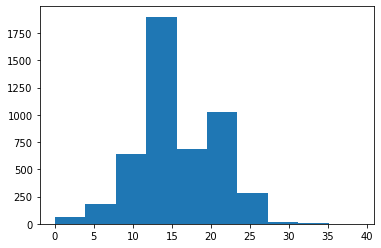

In [150]:
for col in boxed_df:
    plt.figure()
    plt.hist(boxed_df[col])
    print(col)
    plt.show()
del col

In [151]:
no_likes = df_encoded_genres.drop([col for col in df_encoded_genres if "likes" in col], axis=1)

In [152]:
boxed_df.index = no_likes.index

In [153]:
df_boxcoxed_likes = pd.concat([no_likes, boxed_df],axis=1)

In [154]:
df_boxcoxed_likes.head(3)

,original_language,color,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,...,genre_Action,genre_Mystery,genre_Sci-Fi,genre_Adventure,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,Other,Color,The Wailing,The Wailing,곡성,A stranger arrives in a little village and soo...,Unrated,7.7,47098491,10951000.0,...,0,1,0,0,0,4.250035,1.917963,0.000000,3.648834,5.229121
tt5078326,French,Color,The Country Doctor,Irreplaceable,Médecin de campagne,"All the people in this countryside area, can c...",PG-13,7.2,0,19000000.0,...,0,0,0,0,0,7.488314,2.388995,1.198774,2.502277,10.108035
tt5001130,English,Color,Time to Choose,Time to Choose,Time to Choose,Academy Award® winning director Charles Fergus...,PG-13,7.0,0,3500000.0,...,0,0,0,0,1,3.362001,1.461064,0.000000,4.556906,4.057789


### Budget

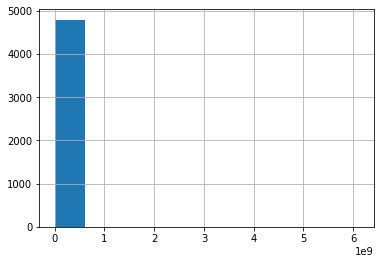

In [155]:
df_boxcoxed_likes.filled_budget.hist()

Also pretty skewed up

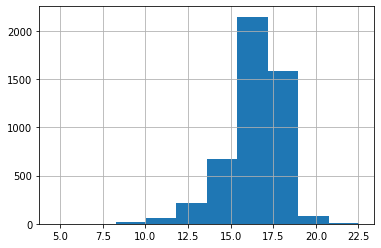

In [156]:
df_boxcoxed_likes.filled_budget.transform(np.log).hist()

Not perfect, boxcox again?

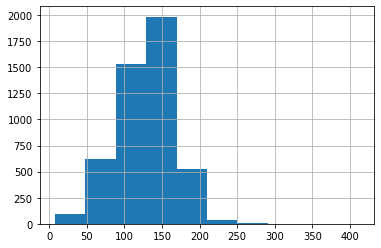

In [157]:
budget_boxed = pd.Series(boxcox(df_boxcoxed_likes.filled_budget)[0], name="budget_boxed")
budget_boxed.hist()

In [158]:
df_boxcoxed_budget = df_boxcoxed_likes.assign(budget_boxed=budget_boxed.values)

In [159]:
df_boxcoxed_budget.head()

,original_language,color,title,movie_title,original_title,overview,content_rating,imdb_score,revenue,filled_budget,...,genre_Mystery,genre_Sci-Fi,genre_Adventure,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box,budget_boxed
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,Other,Color,The Wailing,The Wailing,곡성,A stranger arrives in a little village and soo...,Unrated,7.7,47098491,10951000.0,...,1,0,0,0,4.250035,1.917963,0.000000,3.648834,5.229121,116.223876
tt5078326,French,Color,The Country Doctor,Irreplaceable,Médecin de campagne,"All the people in this countryside area, can c...",PG-13,7.2,0,19000000.0,...,0,0,0,0,7.488314,2.388995,1.198774,2.502277,10.108035,130.009231
tt5001130,English,Color,Time to Choose,Time to Choose,Time to Choose,Academy Award® winning director Charles Fergus...,PG-13,7.0,0,3500000.0,...,0,0,0,1,3.362001,1.461064,0.000000,4.556906,4.057789,91.992876
tt4939066,Other,Color,Operation Chromite,Operation Chromite,인천상륙작전,A squad of soldiers fight in the Korean War's ...,PG-13,6.8,49196532,12660000.0,...,0,0,0,0,12.467224,5.223879,4.491669,3.380737,19.933142,119.709388
tt4871980,English,Color,The Perfect Match,The Perfect Match,The Perfect Match,"Terrence J. stars as Charlie, a playboy who's ...",R,4.5,0,5000000.0,...,0,0,0,0,8.253012,7.951943,10.534436,3.082217,15.201223,98.998224


### Duration

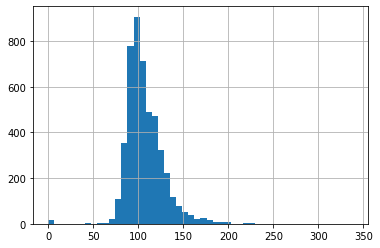

In [160]:
df_boxcoxed_budget.durations.hist(bins=50)

Seems pretty tightly clustered around feature length film length

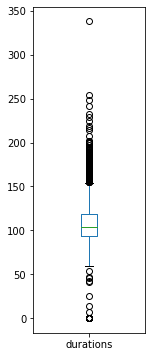

In [161]:
df_boxcoxed_budget.durations.plot(kind='box',figsize=(2,6))

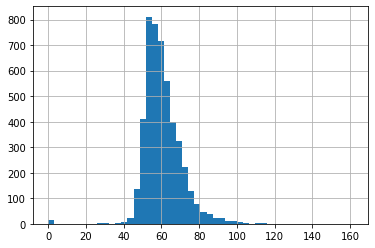

In [162]:
pd.Series(boxcox(df_boxcoxed_budget.durations+1)[0], name=f"duration_box").hist(bins=50)

I think we can just stick with the original durations, no transform needed.

### Number of Production Countries

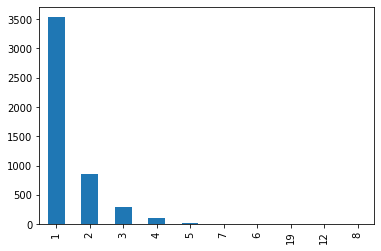

In [163]:
df_boxcoxed_budget.n_production_countries.value_counts().plot(kind='bar')

I should lump together 5+ perhaps...it gets a bit sparse

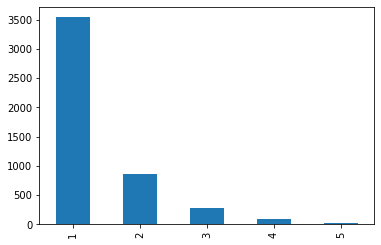

In [164]:
df_boxcoxed_budget.n_production_countries.apply(lambda x: 5 if x >= 5 else x).value_counts().plot(kind='bar')

In [165]:
df_boxcoxed_budget["n_prod_locs_trunc"] = df_boxcoxed_budget.n_production_countries.apply(
                                                                                    lambda x: 5 if x >= 5 else x
                                                                                )

We will need to remember that here, the int 5 represents 5 or more countries of filming.

In [166]:
del df_boxcoxed_budget["n_production_countries"]

### Revenue (Secondary Response Variable)

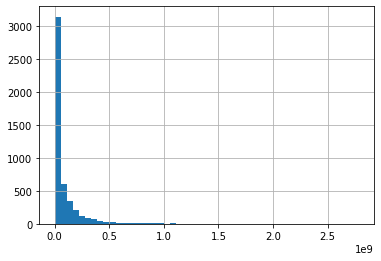

In [167]:
df_boxcoxed_budget.revenue.hist(bins=50)

In [168]:
revenue_boxcox, lambda_revenue_boxcox = boxcox(df_boxcoxed_budget.revenue+1) #Again applying small adjustment for box

with open("../data/pickles/lambda_revenue_boxcox.pkl", "wb") as file:
    pickle.dump(lambda_revenue_boxcox, file)

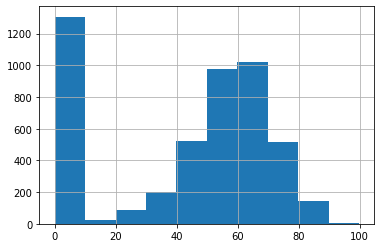

In [169]:
revenue_boxcox = pd.Series(revenue_boxcox,name="revenue_boxcox")
revenue_boxcox.hist()

Still a pretty massive spike around $0 revenue...will this be a problem?

In [170]:
del df_boxcoxed_budget['revenue']

In [171]:
df_boxcox_rev = df_boxcoxed_budget.assign(revenue_boxcox=revenue_boxcox.values)

In [172]:
del df_boxcoxed_budget

In [173]:
df_boxcox_rev.head(3)

,original_language,color,title,movie_title,original_title,overview,content_rating,imdb_score,filled_budget,fixed_aspect,...,genre_Adventure,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box,budget_boxed,n_prod_locs_trunc,revenue_boxcox
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,Other,Color,The Wailing,The Wailing,곡성,A stranger arrives in a little village and soo...,Unrated,7.7,10951000.0,2.39,...,0,0,4.250035,1.917963,0.000000,3.648834,5.229121,116.223876,1,58.752586
tt5078326,French,Color,The Country Doctor,Irreplaceable,Médecin de campagne,"All the people in this countryside area, can c...",PG-13,7.2,19000000.0,1.85,...,0,0,7.488314,2.388995,1.198774,2.502277,10.108035,130.009231,1,0.000000
tt5001130,English,Color,Time to Choose,Time to Choose,Time to Choose,Academy Award® winning director Charles Fergus...,PG-13,7.0,3500000.0,1.85,...,0,1,3.362001,1.461064,0.000000,4.556906,4.057789,91.992876,1,0.000000


### IMdB Score (Response Variable)

In [174]:
df_boxcox_rev.imdb_score.describe()

count    4803.000000
mean        6.412742
std         1.117837
min         1.600000
25%         5.800000
50%         6.500000
75%         7.200000
max         9.300000
Name: imdb_score, dtype: float64

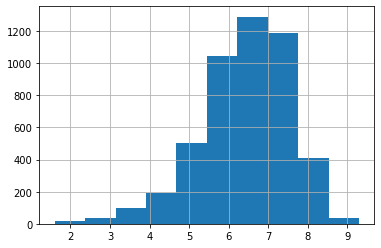

In [175]:
df_boxcox_rev.imdb_score.hist()

Close to normal...

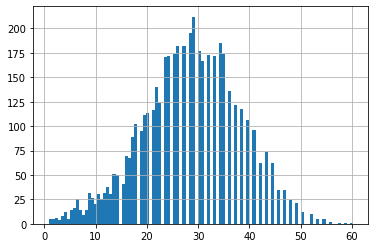

In [176]:
pd.Series(boxcox(df_boxcox_rev.imdb_score)[0], name="imdb_score_boxed").hist(bins=100)

In [177]:
imdb_score_boxed, lambda_imdb_score = boxcox(df_boxcox_rev.imdb_score)

with open("../data/pickles/lambda_imdb_score.pkl", "wb") as file:
    pickle.dump(lambda_imdb_score, file)

In [178]:
df_boxcox_rev['imdb_score_boxed']=boxcox(df_boxcox_rev.imdb_score)[0]

In [179]:
del df_boxcox_rev['imdb_score']

In [180]:
df_boxcox_rev.to_pickle("../data/pickles/df_boxcox_rev.pkl")

## Free Text Columns

In [181]:
df_boxcox_revenue = pd.read_pickle("../data/pickles/df_boxcox_rev.pkl")

### Titles

In [182]:
titles = df_boxcox_revenue["title movie_title original_title".split()]
titles.head(50)

,title,movie_title,original_title
imdb_id,,,
tt5215952,The Wailing,The Wailing,곡성
tt5078326,The Country Doctor,Irreplaceable,Médecin de campagne
tt5001130,Time to Choose,Time to Choose,Time to Choose
tt4939066,Operation Chromite,Operation Chromite,인천상륙작전
tt4871980,The Perfect Match,The Perfect Match,The Perfect Match
tt4824308,God's Not Dead 2,God's Not Dead 2,God's Not Dead 2
tt4786282,Lights Out,Lights Out,Lights Out
tt4733536,American Hero,American Hero,American Hero
tt4707756,The World Is Mine,The World Is Mine,Lumea e a mea


In [183]:
titles['title'].iloc[0] == titles["movie_title"].iloc[0]

False

In [184]:
titles['title'].iloc[0]

'The Wailing'

In [185]:
titles["movie_title"].iloc[0]

'The Wailing\xa0'

In [186]:
titles['movie_title'] = titles['movie_title'].apply(lambda title: normalize('NFKD', title).strip())

/Users/admin/.local/share/virtualenvs/Good-Film-Bad-Film-vaMlpeB4/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [187]:
titles['title'].iloc[0] == titles["movie_title"].iloc[0]

True

In [188]:
titles[titles.title != titles.movie_title].shape

(228, 3)

In [189]:
titles[titles.title != titles.movie_title].head(30)

,title,movie_title,original_title
imdb_id,,,
tt5078326,The Country Doctor,Irreplaceable,Médecin de campagne
tt4704314,To Be Frank: Sinatra at 100,"To Be Frank, Sinatra at 100",To Be Frank: Sinatra at 100
tt4591310,The Monkey King 2,Xi you ji zhi: Sun Wukong san da Baigu Jing,西游记之孙悟空三打白骨精
tt4590482,Karachi Se Lahore,Karachi se Lahore,کراچی سے لاہور
tt4374230,Juliet and Alfa Romeo,Julija in alfa Romeo,Julija in Alfa Romeo
tt4262980,Shin Godzilla,Godzilla Resurgence,シン・ゴジラ
tt4172430,13 Hours: The Secret Soldiers of Benghazi,13 Hours,13 Hours: The Secret Soldiers of Benghazi
tt4075322,Savva. Heart of the Warrior,A Warrior's Tail,Савва. Сердце воина
tt4061848,Alpha and Omega: The Legend of the Saw Tooth Cave,Alpha and Omega 4: The Legend of the Saw Tooth...,Alpha and Omega: The Legend of the Saw Tooth Cave


I can't tell just from looking which of these is the definitive "right" column to use. Original_title seems more likely to be in a foreign language...

In [190]:
titles[titles.title != titles.movie_title].tail(30)

,title,movie_title,original_title
imdb_id,,,
tt0108500,The Visitors,Les visiteurs,Les Visiteurs
tt0107953,Return of the Living Dead 3,Return of the Living Dead III,Return of the Living Dead 3
tt0107659,National Lampoon's Loaded Weapon 1,Loaded Weapon 1,National Lampoon's Loaded Weapon 1
tt0106469,Bound by Honor,"Blood In, Blood Out",Bound by Honor
tt0103874,Dracula,Bram Stoker's Dracula,Dracula
tt0103644,Alien³,Alien 3,Alien³
tt0102510,The Naked Gun 2½: The Smell of Fear,The Naked Gun 21⁄2: The Smell of Fear,The Naked Gun 2½: The Smell of Fear
tt0099685,GoodFellas,Goodfellas,GoodFellas
tt0098724,"sex, lies, and videotape","Sex, Lies, and Videotape","sex, lies, and videotape"


I don't think there is going to be predictive information in the title itself. Maybe I'll just grab one as a plaintext reference to the datapoint...

In [191]:
df_boxcox_revenue.drop(['movie_title', "original_title"],axis=1,inplace=True)

In [192]:
del titles

### Overview / Plot Synopsis

This is where we need to get into real NLP stuff.

Let's have a peek at our plots:

In [193]:
[print(_,"\n") for _ in df_boxcox_revenue.overview.head(10)]

A stranger arrives in a little village and soon after a mysterious sickness starts spreading. A policeman is drawn into the incident and is forced to solve the mystery in order to save his daughter. 

All the people in this countryside area, can count on Jean-Pierre, the doctor who auscultates them, heals and reassures them day and night, 7 days a week. Now Jean-Pierre is sick, so he sees Natalie, a young doctor, coming from the hospital to assist him. But will she adapt to this new life and be able to replace the man that believed to be irreplaceable? 

Academy Award® winning director Charles Ferguson's new film investigates global climate change villains and heroes, and reveals practical solutions to act on. 

A squad of soldiers fight in the Korean War's crucial Battle of Incheon. 

Terrence J. stars as Charlie, a playboy who's convinced that relationships are dead. His two best friends, Donald Faison and Robert C. Riley, bet him that if he sticks to one woman for one month, he's bo

[None, None, None, None, None, None, None, None, None, None]

#### Removing stopwords, POS lemmatization

In [194]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def process_plot(plot):
    tokens = word_tokenize(plot)
    stops_removed = [w for w in tokens if w not in stop_words]
    punc_removed = [w.lower() for w in stops_removed if w.isalpha()]
    tagged = [(w, get_wordnet_pos(w)) for w in punc_removed]
    return " ".join([lemmatizer.lemmatize(word[0], pos=word[1]) for word in tagged])

In [195]:
df_boxcox_revenue['plot_prepped'] = df_boxcox_revenue.overview.apply(process_plot)

#### Binary Count Vectorizing, TF-IDF Normalizing

From the [sklearn docs](https://scikit-learn.org/stable/modules/feature_extraction.html#):

"The word boundaries-aware variant `char_wb` is especially interesting for languages that use white-spaces for word separation...as it...can increase both the predictive accuracy and convergence speed of classifiers trained using such features while retaining the robustness with regards to misspellings and word derivations."

In [196]:
bigram_vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(5, 5),#ngram_range=(1, 2),
                                    token_pattern=r'\b\w+\b', 
                                    min_df=1,
                                    binary=True)

# Plot synopsis texts are not very long: Using binary countvectorizer to help reduce noise

In [197]:
bigram_vectorizer

CountVectorizer(analyzer='char_wb', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(5, 5), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='\\b\\w+\\b', tokenizer=None,
                vocabulary=None)

In [198]:
analyze = bigram_vectorizer.build_analyzer()
analyze('Bi-grams are cool!')

[' bi-g',
 'bi-gr',
 'i-gra',
 '-gram',
 'grams',
 'rams ',
 ' are ',
 ' cool',
 'cool!',
 'ool! ']

In [199]:
sparse_plots = bigram_vectorizer.fit_transform(df_boxcox_revenue['plot_prepped'])
sparse_plots

<4803x40742 sparse matrix of type '<class 'numpy.int64'>'
	with 487817 stored elements in Compressed Sparse Row format>

In [200]:
bigram_columns = bigram_vectorizer.get_feature_names()

In [201]:
bigram_counts = pd.DataFrame(sparse_plots.toarray(),
                             columns=bigram_columns)

bigram_counts.head()

,a,aa,aaa,aame,aang,aaro,aba,abad,abag,aban,...,érôme,ésar,örgy,öves,ørgen,única,ührer,ürren,ładys,ﬁcial
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [202]:
transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(bigram_counts)

In [203]:
df_tfidf = pd.DataFrame(tfidf.toarray(), columns=bigram_columns)
df_tfidf.head()

,a,aa,aaa,aame,aang,aaro,aba,abad,abag,aban,...,érôme,ésar,örgy,öves,ørgen,única,ührer,ürren,ładys,ﬁcial
0,0.052352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.065157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [204]:
del bigram_columns
del bigram_counts
del stop_words
del analyze
del df_boxcox_revenue['overview']
del df_boxcox_revenue['plot_prepped']
del tfidf
del transformer
del wordnet
del lemmatizer
del languages
del sparse_plots
del bigram_vectorizer
del stopwords

In [205]:
df_tfidf.columns[:100]

Index([' a ', ' aa ', ' aaa ', ' aame', ' aang', ' aaro', ' aba ', ' abad',
       ' abag', ' aban', ' abba', ' abbe', ' abbi', ' abbo', ' abby', ' abdi',
       ' abdu', ' abe ', ' abel', ' aber', ' abho', ' abid', ' abig', ' abil',
       ' abla', ' able', ' aboa', ' abod', ' abol', ' abor', ' abou', ' abra',
       ' abro', ' abru', ' abse', ' absh', ' abso', ' abst', ' absu', ' abu ',
       ' abun', ' abus', ' abys', ' acad', ' acap', ' acce', ' acci', ' accl',
       ' acco', ' accr', ' accu', ' ace ', ' ache', ' achi', ' acke', ' acme',
       ' acp ', ' acqu', ' acre', ' acri', ' acro', ' act ', ' acti', ' acto',
       ' actr', ' actu', ' acut', ' ad ', ' ada ', ' adal', ' adam', ' adap',
       ' add ', ' adda', ' addi', ' addr', ' adel', ' adep', ' adib', ' adit',
       ' adja', ' adju', ' adle', ' adm ', ' admi', ' admo', ' adol', ' adon',
       ' adop', ' ador', ' adre', ' adri', ' adul', ' adva', ' adve', ' advi',
       ' advo', ' aegi', ' aeri', ' afar'],
      dtype=

In [206]:
df_tfidf.columns[5000:5100]

Index([' payc', ' payd', ' paym', ' payn', ' payo', ' peac', ' peak', ' pean',
       ' pear', ' peas', ' pebb', ' peck', ' pecu', ' pedd', ' pede', ' pedl',
       ' pedo', ' pedr', ' pee ', ' peeb', ' peek', ' peel', ' peep', ' peer',
       ' peet', ' pegg', ' pei ', ' peka', ' peki', ' pele', ' peli', ' pelt',
       ' pen ', ' pena', ' penc', ' pend', ' pene', ' peng', ' peni', ' penl',
       ' penn', ' pens', ' pent', ' peop', ' pepp', ' pequ', ' per ', ' pera',
       ' perc', ' perd', ' pere', ' perf', ' perh', ' peri', ' perk', ' perm',
       ' pern', ' pero', ' perp', ' perr', ' pers', ' pert', ' peru', ' perv',
       ' peró', ' pesc', ' pesk', ' pest', ' pet ', ' peta', ' pete', ' peti',
       ' petr', ' pett', ' peve', ' peyt', ' pfei', ' pga ', ' phal', ' phan',
       ' phar', ' phas', ' phel', ' phen', ' phi ', ' phil', ' phin', ' phob',
       ' phoe', ' phon', ' phot', ' phra', ' phys', ' pi ', ' pian', ' pica',
       ' picc', ' pick', ' pict', ' pie '],
      dty

In [207]:
df_tfidf.shape

(4803, 40742)

Pretty large feature space there. Maybe I'll incorporate some PCA in the modeling pipeline...

In [208]:
df_boxcox_revenue.to_pickle('../data/pickles/df_mostly_ready_metadata.pkl')
df_tfidf.to_pickle('../data/pickles/df_tfidf.pkl')

***

## Encoding Everything

In [209]:
df_mostly_ready_metadata = pd.read_pickle('../data/pickles/df_mostly_ready_metadata.pkl')

In [210]:
df_mostly_ready_metadata.head(3)

,original_language,color,title,content_rating,filled_budget,fixed_aspect,durations,shot_only_in_USA,shot_in_USA_and_abroad,genre_Drama,...,genre_Documentary,actor_1_facebook_likes_box,actor_2_facebook_likes_box,actor_3_facebook_likes_box,director_facebook_likes_box,cast_total_facebook_likes_box,budget_boxed,n_prod_locs_trunc,revenue_boxcox,imdb_score_boxed
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,Other,Color,The Wailing,Unrated,10951000.0,2.39,156.0,1,0,0,...,0,4.250035,1.917963,0.000000,3.648834,5.229121,116.223876,1,58.752586,39.628994
tt5078326,French,Color,The Country Doctor,PG-13,19000000.0,1.85,102.0,1,0,1,...,0,7.488314,2.388995,1.198774,2.502277,10.108035,130.009231,1,0.000000,34.141130
tt5001130,English,Color,Time to Choose,PG-13,3500000.0,1.85,100.0,0,0,0,...,1,3.362001,1.461064,0.000000,4.556906,4.057789,91.992876,1,0.000000,32.068517


In [211]:
df_mostly_ready_metadata.dtypes

original_language                  object
color                              object
title                              object
content_rating                     object
filled_budget                     float64
fixed_aspect                     category
durations                         float64
shot_only_in_USA                    int64
shot_in_USA_and_abroad              int64
genre_Drama                         int64
genre_Comedy                        int64
genre_Romance                       int64
genre_Crime                         int64
genre_Thriller                      int64
genre_Horror                        int64
genre_Action                        int64
genre_Mystery                       int64
genre_Sci-Fi                        int64
genre_Adventure                     int64
genre_Documentary                   int64
actor_1_facebook_likes_box        float64
actor_2_facebook_likes_box        float64
actor_3_facebook_likes_box        float64
director_facebook_likes_box       

In [212]:
lang_matrix = pd.get_dummies(df_mostly_ready_metadata['original_language'],
                             prefix="lang")
lang_matrix.head()

,lang_English,lang_French,lang_Other,lang_Spanish
imdb_id,,,,
tt5215952,0,0,1,0
tt5078326,0,1,0,0
tt5001130,1,0,0,0
tt4939066,0,0,1,0
tt4871980,1,0,0,0


In [213]:
df_mostly_ready_metadata.drop(['original_language'],axis=1,inplace=True)

In [214]:
df_mostly_ready_metadata = pd.concat([df_mostly_ready_metadata, 
                                      lang_matrix],axis=1)

In [215]:
df_mostly_ready_metadata['color'] = df_mostly_ready_metadata['color'].map({"Color":1,
                                                                           "Black and White":0})

df_mostly_ready_metadata.head()

,color,title,content_rating,filled_budget,fixed_aspect,durations,shot_only_in_USA,shot_in_USA_and_abroad,genre_Drama,genre_Comedy,...,director_facebook_likes_box,cast_total_facebook_likes_box,budget_boxed,n_prod_locs_trunc,revenue_boxcox,imdb_score_boxed,lang_English,lang_French,lang_Other,lang_Spanish
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,1,The Wailing,Unrated,10951000.0,2.39,156.0,1,0,0,0,...,3.648834,5.229121,116.223876,1,58.752586,39.628994,0,0,1,0
tt5078326,1,The Country Doctor,PG-13,19000000.0,1.85,102.0,1,0,1,1,...,2.502277,10.108035,130.009231,1,0.000000,34.141130,0,1,0,0
tt5001130,1,Time to Choose,PG-13,3500000.0,1.85,100.0,0,0,0,0,...,4.556906,4.057789,91.992876,1,0.000000,32.068517,1,0,0,0
tt4939066,1,Operation Chromite,PG-13,12660000.0,1.85,111.0,1,0,1,0,...,3.380737,19.933142,119.709388,1,59.095733,30.065359,0,0,1,0
tt4871980,1,The Perfect Match,R,5000000.0,1.85,96.0,0,0,0,1,...,3.082217,15.201223,98.998224,1,0.000000,11.886995,1,0,0,0


In [216]:
del df_mostly_ready_metadata['title']

In [217]:
df_some_binarized = pd.concat([df_mostly_ready_metadata.drop(['fixed_aspect'],axis=1), 
                                pd.get_dummies(df_mostly_ready_metadata.fixed_aspect, prefix="ratio")],axis=1
                              )

In [218]:
del df_mostly_ready_metadata

In [219]:
df_some_binarized.head()

,color,content_rating,filled_budget,durations,shot_only_in_USA,shot_in_USA_and_abroad,genre_Drama,genre_Comedy,genre_Romance,genre_Crime,...,revenue_boxcox,imdb_score_boxed,lang_English,lang_French,lang_Other,lang_Spanish,ratio_1.33,ratio_1.77,ratio_1.85,ratio_2.39
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,1,Unrated,10951000.0,156.0,1,0,0,0,0,0,...,58.752586,39.628994,0,0,1,0,0,0,0,1
tt5078326,1,PG-13,19000000.0,102.0,1,0,1,1,0,0,...,0.000000,34.141130,0,1,0,0,0,0,1,0
tt5001130,1,PG-13,3500000.0,100.0,0,0,0,0,0,0,...,0.000000,32.068517,1,0,0,0,0,0,1,0
tt4939066,1,PG-13,12660000.0,111.0,1,0,1,0,0,0,...,59.095733,30.065359,0,0,1,0,0,0,1,0
tt4871980,1,R,5000000.0,96.0,0,0,0,1,1,0,...,0.000000,11.886995,1,0,0,0,0,0,1,0


In [220]:
content_ratings = pd.get_dummies(df_some_binarized.content_rating,prefix="content")
content_ratings.head(3)

,content_PG,content_PG-13,content_R,content_Unrated,content_X
imdb_id,,,,,
tt5215952,0,0,0,1,0
tt5078326,0,1,0,0,0
tt5001130,0,1,0,0,0


In [221]:
df_ratings_binarized = pd.concat([df_some_binarized.drop(['content_rating'],
                                                         axis=1
                                                        ), 
                                  content_ratings],
                                 axis=1
                                )

In [222]:
del content_ratings

In [232]:
df_ratings_binarized.head()

,color,filled_budget,durations,shot_only_in_USA,shot_in_USA_and_abroad,genre_Drama,genre_Comedy,genre_Romance,genre_Crime,genre_Thriller,...,lang_Spanish,ratio_1.33,ratio_1.77,ratio_1.85,ratio_2.39,content_PG,content_PG-13,content_R,content_Unrated,content_X
imdb_id,,,,,,,,,,,,,,,,,,,,,
tt5215952,1,10951000.0,156.0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
tt5078326,1,19000000.0,102.0,1,0,1,1,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt5001130,1,3500000.0,100.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt4939066,1,12660000.0,111.0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
tt4871980,1,5000000.0,96.0,0,0,0,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0


In [ ]:
# df_tfidf = pd.read_pickle('../data/pickles/df_tfidf.pkl')

# Bivariate Analyses

Are there any redundant features? Are there any features obviously correlated with our dependent var?

In [ ]:
# Creating a multi-scatter plot
main_corr= main_df.drop(['binary_target'], axis=1).iloc[:,:]
pd.plotting.scatter_matrix(main_corr, figsize=[15,15]);

In [ ]:
sns.heatmap(main_corr.corr(), center=0);

# Structured-Only Linear Regression

Let's start without incorporating the unstructured text data, just numerical and categorical info:

Now that we've cleaned up a bit, we'll start throwing our features at a statsmodels logistic regression estimator to evaluate r^2 and p-values of various features.

In [ ]:
# check LogReg with all initial variables from main_df (note: no plot)
s = ("binary_target ~ Year + C(Action) + C(Adventure) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Crime) + C(Documentary) + C(Drama) + C(Family) + C(Fantasy) + C(History)"
                 "+ C(Horror) + C(Musical) + C(Mystery) + C(Romance) + C(Sci_Fi) + C(Sport)"
                 "+ C(Thriller) + C(War)+ C(Western)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

y, X = dmatrices(s, main_df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

This gives us an idea of which features might be less important in the determination of what makes a movie "good". We'll drop the less pertinent features and try again:

In [ ]:
s = ("binary_target ~ Year + C(Action) + C(Animation) + C(Biography) + C(Comedy)"
                 "+ C(Documentary) + C(Drama) + C(Family)"
                 "+ C(Horror) + C(Mystery) + C(Romance) + C(Sci_Fi)"
                 "+ C(Thriller)"
                 "+ Actor_1_fb_likes_logged + Actor_2_fb_likes_logged"
                 "+ Actor_3_fb_likes_logged")

main_df = main_df.drop(['Adventure','Crime', 'Fantasy', 'History', 'Musical', 'Sport', 'War', 'Western'], axis=1)

y, X = dmatrices(s, main_df, return_type = "dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  0.2)

logit_model = sm.Logit(y_train.iloc[:,0], X_train)
result = logit_model.fit()

print(result.summary())

y_preds = result.predict(X_test)

accuracy_score(y_test, y_preds >=.5)

In [ ]:
main_df.columns

These are the features we're sticking with for now.

It's fairly intuitive that the social media popularity of the leading actors would be positively correlated, but we'll leave it in in case there are deviations from that norm. It's interesting to note that films in the "animation" genre are so commonly also in the "family" genre. Makes sense too.

# LEFTOVERS

## All-Inclusive Model

## Baselining

## Dimensionality Reduction

Next we'll try a simple Gaussian Naive Bayes Model:

Now we'll go nuts and try an XGBClassifier model. A boosted model seems to work better without PCA, so we'll drop it for this part.

## Grid Searching for better parameters